In [1]:
import os
import re
import math
import gzip
import urllib
import string
import tarfile
import requests
import collections
import pandas as pd
import numpy as np
from wordcloud import WordCloud
from datetime import datetime
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import seaborn as sns
import networkx as nx
from scipy import stats
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, auc, roc_curve
import statsmodels.formula.api as smf
import statsmodels.api as sm
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

## Load Data

In [3]:
cmu_path = "data/MovieSummaries/"
corenlp_path = "data/CoreNLP/"
summary_raw_path = corenlp_path+"corenlp_plot_summaries/"
summary_path = corenlp_path+"corenlp_plot_summaries_xml/"
movies_path = cmu_path+"movie.metadata.tsv"
characters_path = cmu_path+"character.metadata.tsv"
plot_path = cmu_path+"plot_summaries.txt"

In [4]:
if not os.path.exists(movies_path):
    movie_url = 'http://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz'
    tar_file = tarfile.open(fileobj=urllib.request.urlopen(movie_url), mode="r:gz") 
    tar_file.extractall(path=movies_path)
    tar_file.close()

In [5]:
# if not os.path.exists(corenlp_path):
#     corenlp_url = 'http://www.cs.cmu.edu/~ark/personas/data/corenlp_plot_summaries.tar'
#     tar_file = tarfile.open(fileobj=urllib.request.urlopen(corenlp_url), mode="r|") 
#     tar_file.extractall(path=corenlp_path)
    
#     os.mkdir(summary_path)
#     for filename in os.listdir(summary_raw_path):
#         f = os.path.join(summary_raw_path, filename) 
#         if os.path.isfile(f):
#             with gzip.open(f, 'rb') as f_in:
#                 gz_file = os.path.join(summary_path, filename)
#                 with open(gz_file[:-3], 'wb') as f_out:
#                     f_out.write(f_in.read())
#     tar_file.close()

In [6]:
movies_column_names = [
    "wikipedia_id",
    "freebase_id",
    "name",
    "release_date",
    "box_office_revenue",
    "runtime",
    "languages",
    "countries",
    "genres"
]

characters_column_names = [
    "wikipedia_id",
    "freebase_id",
    "release_date",
    "character_name",
    "actor_dob",
    "actor_gender",
    "actor_height",
    "actor_ethnicity",
    "actor_name",
    "actor_age",
    "freebase_character_map",
    "freebase_character_id",
    "freebase_actor_id"
]

plot_column_names = ['wikipedia_id', 'summary']

movies = pd.read_csv(movies_path, sep='\t', header=None, names=movies_column_names)
characters = pd.read_csv(characters_path, sep='\t', header=None, names=characters_column_names)
plots = pd.read_csv(plot_path, sep='\t', header=None, names=plot_column_names)

In [7]:
movies.head()

,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [8]:
characters.head()

,wikipedia_id,freebase_id,release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_map,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [9]:
characters.shape

(450669, 13)

In [10]:
movies.shape

(81741, 9)

## Questions:
  Is there any difference on actors' career by genders?

  divide this into 2 sub questions:
  1. Do f/m have equal opportunities as actors? 
    a. Population proportion different?
    b. Age distribution different?  does female have fewer chance when they get older than males? if so, what is the factor?
  2. Do they tend to enjoy similar level of career success? 
      - metric of success: revenue their movies have earned, the social influence of them , the importance of their characters (e.g. by proportion of descriptions in the plot summary.)
      - ... 

### year-grouped analysis

In [11]:
def extract_year(x):
    return str(x)[:4]

In [12]:
characters['movie_year'] = characters['release_date'].apply(extract_year)
characters.head()

,wikipedia_id,freebase_id,release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_map,freebase_character_id,freebase_actor_id,movie_year
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,2001
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,2001
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,2001
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,2001
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,2001


In [13]:
tmp_years = sorted(characters.movie_year.unique())
print(tmp_years[:5], tmp_years[-5:])

['1010', '1888', '1891', '1893', '1894'] ['2013', '2014', '2015', '2016', 'nan']


There is 2 sets of abnormal year data in the dataset:

1. some has <nan> year data, here we just drop them.
2. one movie was release in 2010, but it was mistakenly written as 1010, we correct this.

In [14]:
characters[characters['movie_year']=='nan']

,wikipedia_id,freebase_id,release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_map,freebase_character_id,freebase_actor_id,movie_year
337,27374355,/m/0by1_ff,NaN,NaN,1953-03-16,F,1.60,NaN,Isabelle Huppert,NaN,/m/0bykcy4,NaN,/m/012g92,nan
494,10792038,/m/02qq3mb,NaN,NaN,1950-12-12,M,1.75,/m/0cqgdq,Rajnikanth,NaN,/m/03kxr5d,NaN,/m/02wmbg,nan
519,11717027,/m/02rpz18,NaN,NaN,1908-05-30,M,NaN,/m/041rx,Mel Blanc,NaN,/m/052c_g2,NaN,/m/0c5vh,nan
520,10628777,/m/02qkn7c,NaN,NaN,1964-01-15,F,1.69,NaN,Bhanupriya,NaN,/m/0jmx_q5,NaN,/m/08mdtm,nan
521,10628777,/m/02qkn7c,NaN,NaN,1972-07-18,F,NaN,NaN,Soundarya,NaN,/m/0jmx290,NaN,/m/02vd_b,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450334,29119097,/m/0dlmtgr,NaN,NaN,NaN,M,NaN,NaN,Biswajit Chakraborty,NaN,/m/0hhz7cc,NaN,/m/0dgsd62,nan
450494,17198681,/m/043mrjw,NaN,NaN,1970-03-23,F,NaN,NaN,Melissa Errico,NaN,/m/0cmxspd,NaN,/m/0269llv,nan
450495,17198681,/m/043mrjw,NaN,Barbie Loving Bartender,1965-09-03,M,1.75,/m/042gtr,Charlie Sheen,NaN,/m/04fz126,/m/04fz129,/m/01pllx,nan
450496,17198681,/m/043mrjw,NaN,Make-up Lady,1967-04-02,F,NaN,/m/042gtr,Renée Estevez,NaN,/m/0h5mg_5,/m/0h5mg_7,/m/0331rx,nan


In [15]:
characters[characters['movie_year']=='1010']

,wikipedia_id,freebase_id,release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_map,freebase_character_id,freebase_actor_id,movie_year
67624,29666067,/m/0fphzrf,1010-12-02,Kamuran,1983,M,NaN,NaN,Bartu Küçükçaglayan,NaN,/m/0n4fxh5,/m/0n4fxh8,/m/0df0qkt,1010
67625,29666067,/m/0fphzrf,1010-12-02,Ferman,1941-12-26,M,NaN,NaN,Şener Şen,NaN,/m/0gb33kh,/m/0n4fgzm,/m/02z247j,1010
67626,29666067,/m/0fphzrf,1010-12-02,Idris,1973-04-23,M,NaN,NaN,Cem Yılmaz,NaN,/m/0gb33kn,/m/0n4flr2,/m/0fz9xn,1010
67627,29666067,/m/0fphzrf,1010-12-02,Hasan,1978-12-13,M,NaN,NaN,Okan Yalabık,NaN,/m/0ggd8h0,/m/0n4fsc3,/m/0cmb83k,1010
67628,29666067,/m/0fphzrf,1010-12-02,Battal,1945-07-16,M,NaN,NaN,Çetin Tekindor,NaN,/m/0h9dtmf,/m/0n4frvc,/m/0ch5v5f,1010
67629,29666067,/m/0fphzrf,1010-12-02,Asiye,1985-07-06,F,NaN,NaN,Melisa Sözen,NaN,/m/0k3m4yc,/m/0n4fs00,/m/0ch3v_t,1010
67630,29666067,/m/0fphzrf,1010-12-02,Asit Omer,NaN,M,NaN,NaN,Riza Kocaoglu,NaN,/m/0n4fssj,/m/0n4fssm,/m/0n4fssv,1010
67631,29666067,/m/0fphzrf,1010-12-02,Hatun,NaN,F,NaN,NaN,Nergis Çorakçi,NaN,/m/0n4ftj1,/m/0n4ftj4,/m/0n4ftjc,1010
67632,29666067,/m/0fphzrf,1010-12-02,Müslüm,1963,M,NaN,NaN,Mustafa Avkiran,NaN,/m/0n4fv9p,/m/0n4fv9s,/m/0gc9xb7,1010
67633,29666067,/m/0fphzrf,1010-12-02,Murat Önes,NaN,M,NaN,NaN,Mahir Ipek,NaN,/m/0n4fvtw,/m/0n4fvtz,/m/0n4fvv5,1010


In [16]:
characters.loc[characters['movie_year']=='1010','movie_year']='2010'

In [17]:
characters_with_year = characters[characters['movie_year']!='nan']

characters_with_year['movie_year'] = characters_with_year['movie_year'].apply(lambda x: int(x))
print(characters_with_year.shape)
characters_with_year.head()

(440674, 14)


/var/folders/kc/568hl5mn7tv3f90kll8cmsrr0000gn/T/ipykernel_6239/99160358.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  characters_with_year['movie_year'] = characters_with_year['movie_year'].apply(lambda x: int(x))


,wikipedia_id,freebase_id,release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_map,freebase_character_id,freebase_actor_id,movie_year
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,2001
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,2001
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,2001
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,2001
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,2001


## Actor age evolution for genders

In [18]:
female = characters_with_year[characters_with_year['actor_gender']=='F']
male = characters_with_year[characters_with_year['actor_gender']=='M']

female_age = female[female['actor_age']>=0][['actor_age','movie_year']]
male_age = male[male['actor_age']>=0][['actor_age','movie_year']]

female_age.head()

,actor_age,movie_year
0,42.0,2001
1,27.0,2001
4,23.0,2001
5,52.0,2001
6,56.0,2001


In [19]:
print(female_age[female_age['movie_year']<1920].shape)
print(male_age[male_age['movie_year']<1920].shape)

(110, 2)
(36, 2)


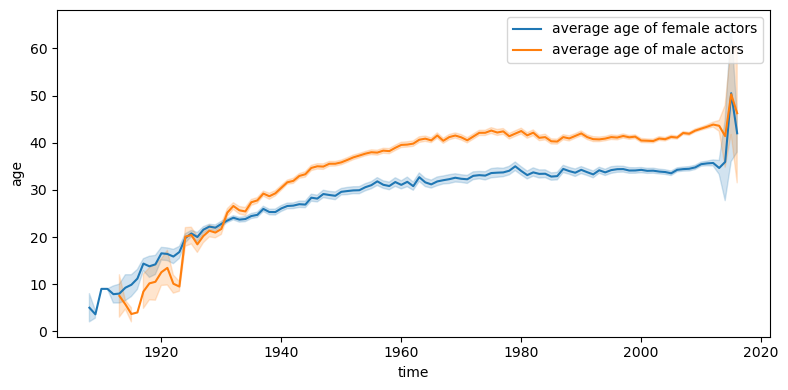

In [20]:
plt.figure(figsize=(8,4))

ax = sns.lineplot(
    data = female_age, x = "movie_year", y = 'actor_age',
    legend = "full", label = "average age of female actors"

    )
ax = sns.lineplot(
    data = male_age, x = "movie_year", y = 'actor_age' ,
    legend = "full", label = "average age of male actors"
    )
plt.xlabel("time")
plt.ylabel("age")
plt.tight_layout()
plt.show()

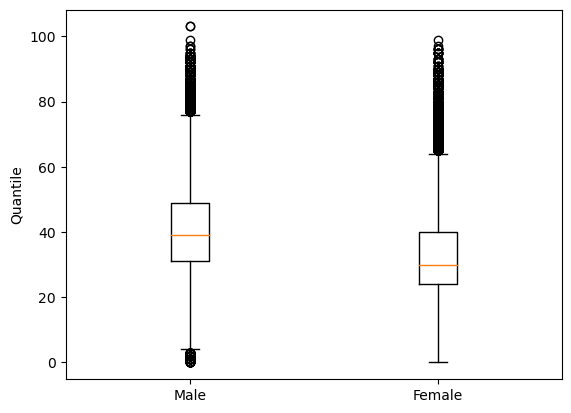

In [81]:
# age_dis = [female_age['actor_age'].values, male_age['actor_age'].values]
age_dis = [male_age['actor_age'].values, female_age['actor_age'].values]
# plt.boxplot(age_dis, labels={'Male', 'Female'})
plt.boxplot(age_dis, labels={'Female', 'Male'})
plt.ylabel("Quantile")
plt.title("Age distribution of male and female characters")
plt.show()


In [22]:
stats.ttest_ind(female_age['actor_age'], male_age['actor_age'])

Ttest_indResult(statistic=-140.92509242040052, pvalue=0.0)

### Analysis of age plots
- ttest p value equals zero, which means mean value of the two distribution are totally different
- The lineplots also show the average age actors through years. Female actors are generally younger than male actors when they play actors in movies since 1935s. From 1925s to 1935s, average age is roughly same. From 1915s to 1925s, female actors are younger. For previous years, the total actor counts of whom are notated with yearsare less than 50, it is too small a dataset size to draw some feasible conclustions. 
- The lineplots also shows an ascending trend in age of both female and male actors, but with different time periods and gradually become flat in recent years. 

filter abnormal data

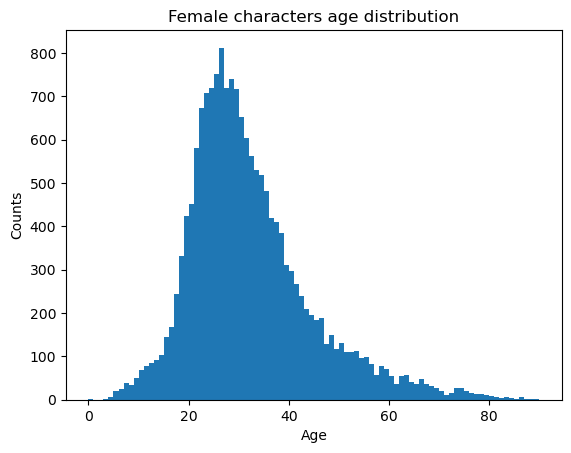

In [75]:
# max = 90
female_filtered= female.drop(female[female['actor_age']<0].index).dropna()
female_filtered.actor_age.plot(kind = "hist", bins = 90)
plt.title("Female characters age distribution")
plt.xlabel("Age")
plt.ylabel("Counts")
plt.show()

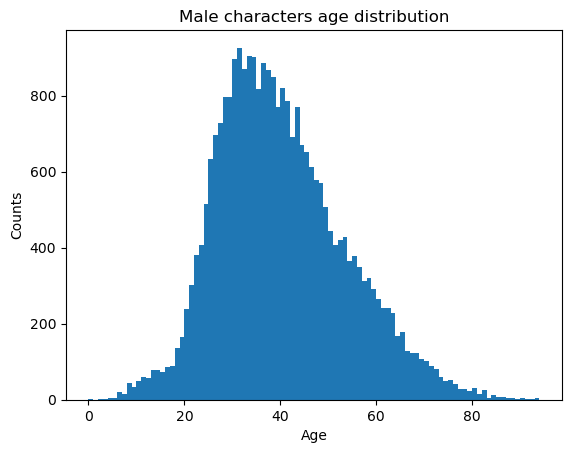

In [74]:
# max = 94
male_filtered= male.drop(male[male['actor_age']<0].index).dropna()
male_filtered.actor_age.plot(kind = "hist", bins = 94)
plt.title("Male characters age distribution")
plt.xlabel("Age")
plt.ylabel("Counts")
plt.show()

In [27]:
def find_age_range(df):
    grouped = df.groupby(by =  'freebase_actor_id')
    ages = grouped.agg({'actor_name': lambda x: x.mode(), 'actor_age':['min', 'max',lambda x: np.mean(x.mode())]}).reset_index()
    ages['span'] = ages['actor_age','max']-ages['actor_age','min']+1
    return ages

female_age_span = find_age_range(female_filtered)
male_age_span = find_age_range(male_filtered)

In [28]:
female_age_span.span.describe()

count    1462.000000
mean       14.076607
std        12.698457
min         1.000000
25%         4.000000
50%        11.000000
75%        20.000000
max        69.000000
Name: span, dtype: float64

In [29]:
male_age_span.span.describe()

count    1857.000000
mean       17.602585
std        13.765014
min         1.000000
25%         7.000000
50%        15.000000
75%        26.000000
max        74.000000
Name: span, dtype: float64

In [30]:
stats.ttest_ind(female_age_span.span, male_age_span.span,alternative = 'less')

Ttest_indResult(statistic=-7.579058102005843, pvalue=2.2444630262020802e-14)

In [31]:
stats.kstest(female_age_span.span, male_age_span.span, alternative='greater')

KstestResult(statistic=0.1307799747618174, pvalue=6.214787048536377e-13)

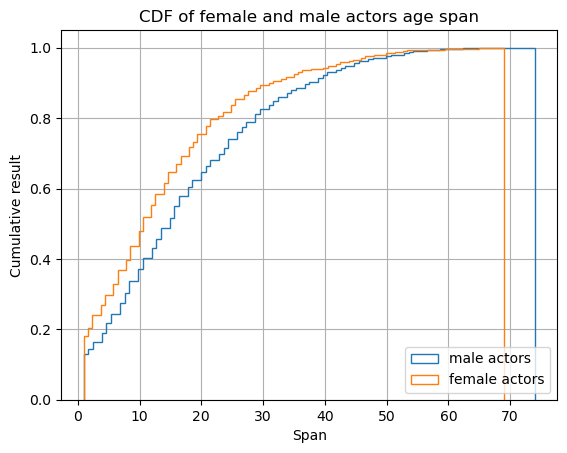

In [82]:
ax = male_age_span.span.hist( cumulative = True, density=1, bins =100, histtype = 'step', label='male actors' )
ax = female_age_span.span.hist( cumulative = True, density=1, bins =100, histtype = 'step', label='female actors' )
plt.legend(loc = "lower right")
plt.title('CDF of female and male actors age span')
plt.xlabel('Span')
plt.ylabel('Cumulative result')
plt.show()

### Analysis of age span
- In the description, mean, 25%-50%-75% quantiles of female actor age span are all smaller than male's.
- From ttest result, we see the average of female actor age span is indeed smaller than male's.
- From the kstest result and cdf plots we see in CDF of female actor age span $F(x)$ and male age span $G(x)$, for every x, $F(x)$ is greater than $G(x)$, which means the general career length of female actors are shorter than male actors.

## Gender difference on character population

In [33]:
female_year_grouped = female.groupby(by='movie_year')
male_year_grouped= male.groupby(by='movie_year')

In [34]:
female_years = pd.DataFrame(columns=['nums'])
female_years['nums'] = female_year_grouped.size()
male_years = pd.DataFrame(columns=['nums'])
male_years['nums'] = male_year_grouped.size()


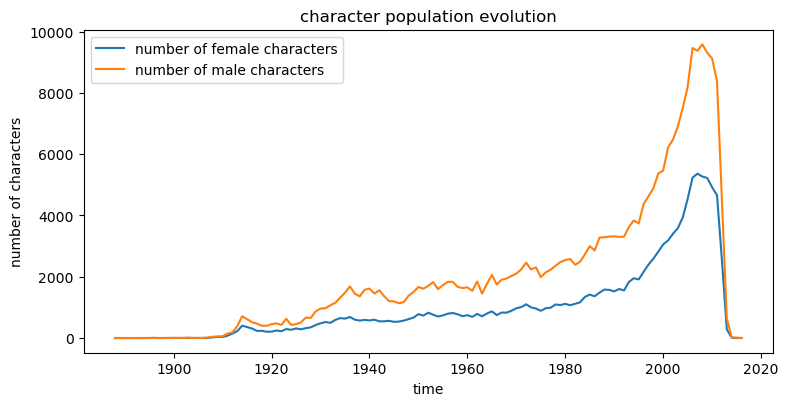

In [70]:
plt.figure(figsize=(8,4))


ax = sns.lineplot(data = female_years, x = "movie_year", y = "nums", legend = "full", label = "number of female characters")
ax = sns.lineplot(data = male_years, x = "movie_year", y = "nums", legend = "full", label = "number of male characters")


plt.xlabel("time")
plt.ylabel("number of characters")
plt.tight_layout()
plt.title("character population evolution")
plt.show()

126 121


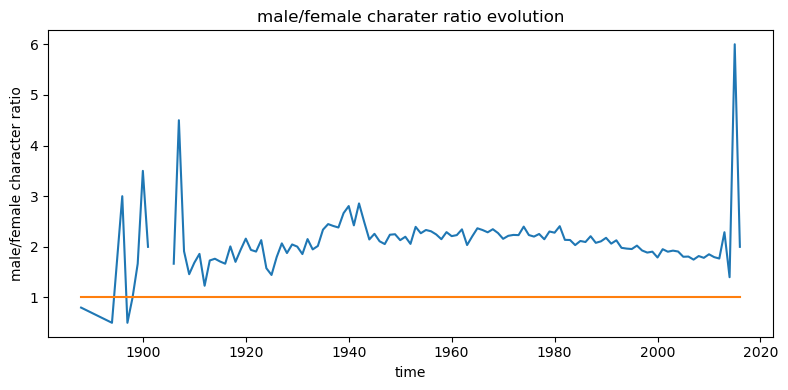

In [71]:
plt.figure(figsize=(8,4))

ratio = male_years / female_years
print(len(male_years), len(female_years))

# since female_years is shorter
length = len(female_years)
plt.plot(female_years.index, ratio[-length:])
plt.plot(female_years.index, np.ones(len(female_years)))

plt.xlabel("time")
plt.ylabel("male/female character ratio")

plt.title("male/female charater ratio evolution")

plt.tight_layout()
plt.show()

In [37]:
print([idx if idx not in female_years.index else '' for idx in male_years.index ])


['', 1891, 1893, '', 1895, '', '', '', '', '', '', '', '', 1904, 1905, '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


### Analysis of actor population ratio
Male characters are always more than female characters, showing insufficient opportunities of female actresses. Why?
Possible reasons:
1. Gender proportion of one movie is highly affected by its genre. Maybe "male movies" like war movies are preferred by the market.
2. Stereotype influence are so strong that people seldom break the existing personas given to women.
3. Social influence: when people tend to cooperate with whom they have already been familiar with, the existing relationship with male actors give them more chance.

## Future work:


The plots above show that: 1. female characters are far fewer than male actors, and the opportunities are not equally given. 2. female actors are generally younger than male actors, meaning that female actors have a shorter career span than male actors. What leads to this phenomenon? We will investigate through 4 main directions: market preference, the social influence of actors, stereotypes in movies, and the general lack of opportunities for women in all professions.

To answer the second question, we need first to define success. We will define a function that aggregates both revenues actors made and their industrial influence based on the following discussed social network, which is to be implemented and refined afterwards.

## Market preference

In [83]:
movies['movie_year'] = movies['release_date'].apply(extract_year)
movies.head()

,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres,movie_year
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1987
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983


In [84]:
movies_revenue = movies.loc[movies.box_office_revenue.dropna().index].reset_index()
movies_revenue.head()

,index,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres,movie_year
0,0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001
1,7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938
2,13,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",1989
3,17,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",1964
4,21,612710,/m/02wjqm,New Rose Hotel,1999-10-01,21521.0,92.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",1999


In [85]:
movies_revenue.box_office_revenue.describe()

count    8.401000e+03
mean     4.799363e+07
std      1.121753e+08
min      1.000000e+04
25%      2.083193e+06
50%      1.063969e+07
75%      4.071696e+07
max      2.782275e+09
Name: box_office_revenue, dtype: float64

<AxesSubplot:ylabel='Frequency'>

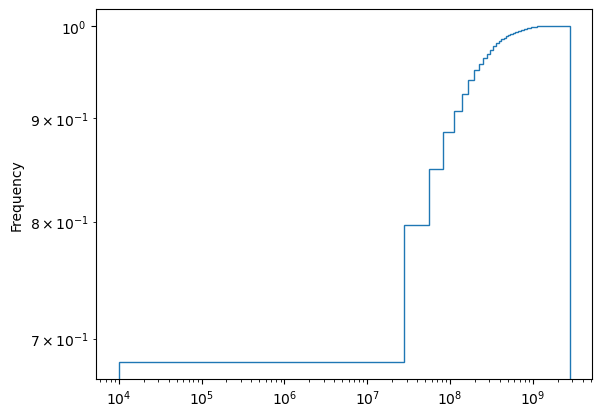

In [86]:
movies_revenue.box_office_revenue.plot(
    cumulative = True, 
    density = 1, kind = 'hist', 
    bins = np.logspace(
        np.log10(movies_revenue.box_office_revenue.min()),
        np.log10(movies_revenue.box_office_revenue.max()), 
        50), 
    loglog=True, 
    histtype = 'step')

In [87]:
def get_movie_ch_counts(df):
    ch_movies = df[df['freebase_id'].isin(movies_revenue['freebase_id'])].groupby(by='freebase_id').character_name.count()
    return(ch_movies)

f_movie_counts = get_movie_ch_counts(female)
m_movie_counts = get_movie_ch_counts(male)

In [101]:
if 'freebase_id' in movies_revenue.columns: 
    movies_revenue = movies_revenue.set_index('freebase_id')
movies_revenue['female_counts'] = f_movie_counts
movies_revenue['male_counts'] = m_movie_counts
movies_revenue.head()

,index,wikipedia_id,name,release_date,box_office_revenue,runtime,languages,countries,genres,movie_year,female_counts,male_counts
freebase_id,,,,,,,,,,,,
/m/03vyhn,0,975900,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,5.0,11.0
/m/02qc0j7,7,10408933,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938,0.0,1.0
/m/016ywb,13,171005,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",1989,2.0,4.0
/m/0kcn7,17,77856,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",1964,6.0,7.0
/m/02wjqm,21,612710,New Rose Hotel,1999-10-01,21521.0,92.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",1999,2.0,1.0


In [103]:
# drop movies with no actor infomation
gender_movie_revenue = movies_revenue.dropna(how = 'all', subset=['female_counts', 'male_counts'])
gender_movie_revenue = gender_movie_revenue.fillna(0)
gender_movie_revenue = gender_movie_revenue[(gender_movie_revenue['female_counts']!=0) | (gender_movie_revenue['male_counts']!=0)]
gender_movie_revenue.head()

,index,wikipedia_id,name,release_date,box_office_revenue,runtime,languages,countries,genres,movie_year,female_counts,male_counts
freebase_id,,,,,,,,,,,,
/m/03vyhn,0,975900,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,5.0,11.0
/m/02qc0j7,7,10408933,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938,0.0,1.0
/m/016ywb,13,171005,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",1989,2.0,4.0
/m/0kcn7,17,77856,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",1964,6.0,7.0
/m/02wjqm,21,612710,New Rose Hotel,1999-10-01,21521.0,92.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",1999,2.0,1.0


In [105]:
gender_movie_revenue['gender_diff'] = gender_movie_revenue['male_counts'] - gender_movie_revenue['female_counts']
gender_movie_revenue['total_ch'] = gender_movie_revenue['male_counts'] + gender_movie_revenue['female_counts']
gender_movie_revenue['log_rev'] = np.log(gender_movie_revenue['box_office_revenue'])
# use regulized ration in case of 0 counts
gender_movie_revenue['reg_ratio'] = (gender_movie_revenue['male_counts'] +1 )/ (gender_movie_revenue['female_counts']+1)

In [119]:
# standardlization
gender_movie_revenue['std_total_ch']  = (gender_movie_revenue['total_ch']-gender_movie_revenue['total_ch'].mean())/gender_movie_revenue['total_ch'].std()
gender_movie_revenue['std_revenue']  = (gender_movie_revenue['box_office_revenue']-gender_movie_revenue['box_office_revenue'].mean())/gender_movie_revenue['box_office_revenue'].std()
gender_movie_revenue['std_runtime'] = (gender_movie_revenue['runtime']-gender_movie_revenue['runtime'].mean())/gender_movie_revenue['runtime'].std()
gender_movie_revenue.movie_year = gender_movie_revenue.movie_year.apply(lambda x: int(x))
gender_movie_revenue['std_year']  = (gender_movie_revenue['movie_year']-gender_movie_revenue['movie_year'].mean())/gender_movie_revenue['movie_year'].std()


In [118]:
gender_movie_revenue.reg_ratio.describe()

count    7036.000000
mean        2.027252
std         1.786494
min         0.066667
25%         1.000000
50%         1.600000
75%         2.500000
max        30.000000
Name: reg_ratio, dtype: float64

In [121]:
model = smf.ols(formula='std_revenue ~ std_total_ch + reg_ratio + std_year + std_runtime', data=gender_movie_revenue)
np.random.seed(2)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:            std_revenue   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     386.4
Date:                Tue, 20 Dec 2022   Prob (F-statistic):          2.75e-301
Time:                        10:59:32   Log-Likelihood:                -9284.1
No. Observations:                7036   AIC:                         1.858e+04
Df Residuals:                    7031   BIC:                         1.861e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0402      0.017     -2.418   

eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


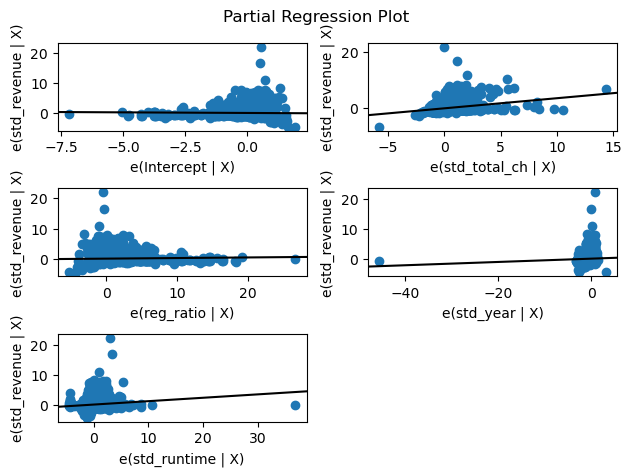

In [122]:
fig = sm.graphics.plot_partregress_grid(result)
fig.tight_layout(pad=1.0)

### Analysis
- Regression show a slightly positive cooeficient of male/female actor ratio on the box office revenue of movies.
- This might be one of the reasons why male characters are more than female characters.